In [51]:
import anthropic

# load dotenv for the api_key
import os
from dotenv import load_dotenv
load_dotenv()

client = anthropic.Anthropic(
    # defaults to os.environ.get("ANTHROPIC_API_KEY")
    api_key = os.getenv("ANTHROPIC_API_KEY"),
)


import json

def save_data(message, name_of_file='augmented_dark_pattern_claude.json'):
    # Cargar los datos existentes
    try:
        with open(name_of_file, 'r') as f:
            resultados = json.load(f)
    except FileNotFoundError:
        print("File not found")
        print("Creating a new file")
        resultados = []

    # Agregar los nuevos datos
    nuevos_datos = json.loads(message.json())
    resultados.append(nuevos_datos)

    # Guardar los datos actualizados
    with open(name_of_file, 'w') as f:
        json.dump(resultados, f)

    print(f"Data saved in {name_of_file}")
    print("The length of the dataset after appending the new message is: ", len(resultados))

### Load original data

In [149]:
import pandas as pd
from tqdm import tqdm
import time

df_original = pd.read_csv("./data/dataset.tsv", sep="\t")

# get a sample of the dataset
sample = df_original.sample(100, random_state=2024)

sample.value_counts("label")
        

label
1    51
0    49
dtype: int64

In [151]:
df_original.shape

(2356, 4)

In [150]:
# prepare the data for the API
for data in tqdm(sample.to_dict(orient="records"), desc="Sending data to the API"):
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": f"Original Data: \"{data['text']}\"\nOringinal Label: {data['label']}",
                }
            ],
        }
    ]
    message = client.messages.create(
        model="claude-3-haiku-20240307",
        max_tokens=1000,
        temperature=0,
        system='Your role is to act as a data augmentation tool focused on generating data variations for dark patterns. Dark patterns are deceptive designs in user interfaces intended to make users behave in ways they do not intend.\n\nGiven the input data, generate three variations for data augmentation. Two variations should maintain the original label, while one should be altered significantly enough to belong to the opposite category. The categories for labeling are: 0 for \'Not Dark Pattern\', and 1 for \'Dark Pattern\'. Each variation should strive to maintain the core characteristics of the original input but alter aspects such as wording, structure, etc., to enhance model training diversity.\n\nAdditionally, for each augmented data, provide a \'Confidence\' score between 0 and 1 that represents how well the new variations adhere to the assigned label and the quality of the variation.\n\nPlease return the output in the following JSON format:\n\n{\n  "Original Data": "[Original Text]",\n  "Original Label": "[Appropriate Category]",\n  "Augmented Variations": [\n    {\n      "Augmented Data": "[Variation 1]",\n      "Label": "[Appropriate Category]",\n      "Confidence": "[Confidence Score]"\n    },\n    {\n      "Augmented Data": "[Variation 2]",\n      "Label": "[Appropriate Category]",\n      "Confidence": "[Confidence Score]"\n    },\n    {\n      "Augmented Data": "[Variation 3]",\n      "Label": "[Appropriate Category]",\n      "Confidence": "[Confidence Score]"\n    }\n  ]\n}\n',
        messages=messages,
    )

    # save the data
    name_of_file='augmented_dark_pattern_claude.json'
    save_data(message, name_of_file)

    # Esperar 30 segundos con la barra de progreso de tqdm
    for i in tqdm(range(30), desc="Waiting for 30 seconds"):
        time.sleep(1)

Sending data to the API:   0%|          | 0/100 [00:00<?, ?it/s]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  223


Sending data to the API:   1%|          | 1/100 [00:32<53:27, 32.40s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  224


Sending data to the API:   2%|▏         | 2/100 [01:05<53:35, 32.81s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  225


Sending data to the API:   3%|▎         | 3/100 [01:37<52:46, 32.64s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  226


Sending data to the API:   4%|▍         | 4/100 [02:10<51:57, 32.48s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  227


Sending data to the API:   5%|▌         | 5/100 [02:44<52:29, 33.16s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  228


Sending data to the API:   6%|▌         | 6/100 [03:17<51:49, 33.08s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  229


Sending data to the API:   7%|▋         | 7/100 [03:50<51:07, 32.99s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  230


Sending data to the API:   8%|▊         | 8/100 [04:25<51:39, 33.69s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  231


Sending data to the API:   9%|▉         | 9/100 [04:58<50:39, 33.40s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  232


Sending data to the API:  10%|█         | 10/100 [05:30<49:33, 33.04s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  233


Sending data to the API:  11%|█         | 11/100 [06:02<48:40, 32.81s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  234


Sending data to the API:  12%|█▏        | 12/100 [06:35<48:04, 32.78s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  235


Sending data to the API:  13%|█▎        | 13/100 [07:08<47:44, 32.92s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  236


Sending data to the API:  14%|█▍        | 14/100 [07:41<47:16, 32.99s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  237


Sending data to the API:  15%|█▌        | 15/100 [08:14<46:32, 32.85s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  238


Sending data to the API:  16%|█▌        | 16/100 [08:46<45:43, 32.65s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  239


Sending data to the API:  17%|█▋        | 17/100 [09:19<45:05, 32.60s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  240


Sending data to the API:  18%|█▊        | 18/100 [09:52<44:50, 32.81s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  241


Sending data to the API:  19%|█▉        | 19/100 [10:24<44:10, 32.73s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  242


Sending data to the API:  20%|██        | 20/100 [10:57<43:39, 32.75s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  243


Sending data to the API:  21%|██        | 21/100 [11:30<43:11, 32.80s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  244


Sending data to the API:  22%|██▏       | 22/100 [12:02<42:23, 32.61s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  245


Sending data to the API:  23%|██▎       | 23/100 [12:35<41:52, 32.63s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  246


Sending data to the API:  24%|██▍       | 24/100 [13:08<41:20, 32.64s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  247


Sending data to the API:  25%|██▌       | 25/100 [13:40<40:36, 32.48s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  248


Sending data to the API:  26%|██▌       | 26/100 [14:12<39:57, 32.40s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  249


Sending data to the API:  27%|██▋       | 27/100 [14:44<39:22, 32.37s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  250


Sending data to the API:  28%|██▊       | 28/100 [15:17<38:48, 32.35s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  251


Sending data to the API:  29%|██▉       | 29/100 [15:49<38:16, 32.34s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  252


Sending data to the API:  30%|███       | 30/100 [16:21<37:48, 32.41s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  253


Sending data to the API:  31%|███       | 31/100 [16:55<37:40, 32.76s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  254


Sending data to the API:  32%|███▏      | 32/100 [17:27<36:57, 32.60s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  255


Sending data to the API:  33%|███▎      | 33/100 [18:00<36:24, 32.60s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  256


Sending data to the API:  34%|███▍      | 34/100 [18:32<35:51, 32.60s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  257


Sending data to the API:  35%|███▌      | 35/100 [19:05<35:19, 32.61s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  258


Sending data to the API:  36%|███▌      | 36/100 [19:38<34:50, 32.66s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  259


Sending data to the API:  37%|███▋      | 37/100 [20:11<34:20, 32.70s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  260


Sending data to the API:  38%|███▊      | 38/100 [20:44<33:58, 32.88s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  261


Sending data to the API:  39%|███▉      | 39/100 [21:17<33:32, 33.00s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  262


Sending data to the API:  40%|████      | 40/100 [21:50<32:51, 32.86s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  263


Sending data to the API:  41%|████      | 41/100 [22:23<32:17, 32.84s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  264


Sending data to the API:  42%|████▏     | 42/100 [22:56<31:53, 32.98s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  265


Sending data to the API:  43%|████▎     | 43/100 [23:28<31:08, 32.79s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  266


Sending data to the API:  44%|████▍     | 44/100 [24:01<30:40, 32.87s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  267


Sending data to the API:  45%|████▌     | 45/100 [24:34<29:58, 32.70s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  268


Sending data to the API:  46%|████▌     | 46/100 [25:08<29:53, 33.20s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  269


Sending data to the API:  47%|████▋     | 47/100 [25:41<29:17, 33.17s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  270


Sending data to the API:  48%|████▊     | 48/100 [26:14<28:39, 33.06s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  271


Sending data to the API:  49%|████▉     | 49/100 [26:47<28:09, 33.13s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  272


Sending data to the API:  50%|█████     | 50/100 [27:21<27:40, 33.21s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  273


Sending data to the API:  51%|█████     | 51/100 [27:53<26:59, 33.05s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  274


Sending data to the API:  52%|█████▏    | 52/100 [28:26<26:16, 32.85s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  275


Sending data to the API:  53%|█████▎    | 53/100 [28:58<25:42, 32.81s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  276


Sending data to the API:  54%|█████▍    | 54/100 [29:31<25:08, 32.80s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  277


Sending data to the API:  55%|█████▌    | 55/100 [30:04<24:37, 32.84s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  278


Sending data to the API:  56%|█████▌    | 56/100 [30:37<24:03, 32.80s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  279


Sending data to the API:  57%|█████▋    | 57/100 [31:09<23:26, 32.71s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  280


Sending data to the API:  58%|█████▊    | 58/100 [31:42<22:50, 32.62s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  281


Sending data to the API:  59%|█████▉    | 59/100 [32:16<22:40, 33.18s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  282


Sending data to the API:  60%|██████    | 60/100 [32:49<22:07, 33.20s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  283


Sending data to the API:  61%|██████    | 61/100 [33:22<21:33, 33.16s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  284


Sending data to the API:  62%|██████▏   | 62/100 [33:56<21:00, 33.16s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  285


Sending data to the API:  63%|██████▎   | 63/100 [34:28<20:21, 33.02s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  286


Sending data to the API:  64%|██████▍   | 64/100 [35:02<19:56, 33.24s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  287


Sending data to the API:  65%|██████▌   | 65/100 [35:36<19:27, 33.34s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  288


Sending data to the API:  66%|██████▌   | 66/100 [36:08<18:45, 33.10s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  289


Sending data to the API:  67%|██████▋   | 67/100 [36:41<18:06, 32.91s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  290


Sending data to the API:  68%|██████▊   | 68/100 [37:13<17:30, 32.83s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  291


Sending data to the API:  69%|██████▉   | 69/100 [37:45<16:51, 32.64s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  292


Sending data to the API:  70%|███████   | 70/100 [38:18<16:20, 32.68s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  293


Sending data to the API:  71%|███████   | 71/100 [38:51<15:48, 32.69s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  294


Sending data to the API:  72%|███████▏  | 72/100 [39:27<15:42, 33.66s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  295


Sending data to the API:  73%|███████▎  | 73/100 [40:00<15:05, 33.55s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  296


Sending data to the API:  74%|███████▍  | 74/100 [40:33<14:28, 33.40s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  297


Sending data to the API:  75%|███████▌  | 75/100 [41:06<13:50, 33.22s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  298


Sending data to the API:  76%|███████▌  | 76/100 [41:40<13:23, 33.46s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  299


Sending data to the API:  77%|███████▋  | 77/100 [42:12<12:41, 33.10s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  300


Sending data to the API:  78%|███████▊  | 78/100 [42:45<12:06, 33.02s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  301


Sending data to the API:  79%|███████▉  | 79/100 [43:18<11:31, 32.93s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  302


Sending data to the API:  80%|████████  | 80/100 [43:50<10:54, 32.74s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  303


Sending data to the API:  81%|████████  | 81/100 [44:23<10:20, 32.65s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  304


Sending data to the API:  82%|████████▏ | 82/100 [44:55<09:47, 32.62s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  305


Sending data to the API:  83%|████████▎ | 83/100 [45:28<09:15, 32.67s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  306


Sending data to the API:  84%|████████▍ | 84/100 [46:01<08:42, 32.66s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  307


Sending data to the API:  85%|████████▌ | 85/100 [46:34<08:12, 32.85s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  308


Sending data to the API:  86%|████████▌ | 86/100 [47:06<07:38, 32.73s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  309


Sending data to the API:  87%|████████▋ | 87/100 [47:39<07:04, 32.68s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  310


Sending data to the API:  88%|████████▊ | 88/100 [48:11<06:31, 32.63s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  311


Sending data to the API:  89%|████████▉ | 89/100 [48:44<05:57, 32.54s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  312


Sending data to the API:  90%|█████████ | 90/100 [49:16<05:25, 32.59s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  313


Sending data to the API:  91%|█████████ | 91/100 [49:49<04:52, 32.50s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  314


Sending data to the API:  92%|█████████▏| 92/100 [50:22<04:22, 32.77s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  315


Sending data to the API:  93%|█████████▎| 93/100 [50:55<03:49, 32.77s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  316


Sending data to the API:  94%|█████████▍| 94/100 [51:27<03:15, 32.66s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  317


Sending data to the API:  95%|█████████▌| 95/100 [52:00<02:42, 32.56s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  318


Sending data to the API:  96%|█████████▌| 96/100 [52:34<02:12, 33.01s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  319


Sending data to the API:  97%|█████████▋| 97/100 [53:07<01:39, 33.20s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  320


Sending data to the API:  98%|█████████▊| 98/100 [53:41<01:06, 33.27s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  321


Sending data to the API:  99%|█████████▉| 99/100 [54:13<00:33, 33.09s/it]

Data saved in augmented_dark_pattern_claude.json
The length of the dataset after appending the new message is:  322


Sending data to the API: 100%|██████████| 100/100 [54:46<00:00, 32.87s/it]


#### API Call to Augmente Data

In [53]:

message = client.messages.create(
    model="claude-3-haiku-20240307",
    max_tokens=1000,
    temperature=0,
    system="Your role is to act as a data augmentation tool focused on generating data variations for dark patterns. Dark patterns are deceptive designs in user interfaces intended to make users behave in ways they do not intend.\n\nGiven the input data, generate three variations for data augmentation. Two variations should maintain the original label, while one should be altered significantly enough to belong to the opposite category. The categories for labeling are: 0 for 'Not Dark Pattern', and 1 for 'Dark Pattern'. Each variation should strive to maintain the core characteristics of the original input but alter aspects such as wording, structure, etc., to enhance model training diversity.\n\nAdditionally, for each augmented data, provide a 'Confidence' score between 0 and 1 that represents how well the new variations adhere to the assigned label and the quality of the variation.\n\nPlease return the output in the following JSON format:\n\n{\n  \"Original Data\": \"[Original Text]\",\n  \"Original Label\": \"[Appropriate Category]\",\n  \"Augmented Variations\": [\n    {\n      \"Augmented Data\": \"[Variation 1]\",\n      \"Label\": \"[Appropriate Category]\",\n      \"Confidence\": \"[Confidence Score]\"\n    },\n    {\n      \"Augmented Data\": \"[Variation 2]\",\n      \"Label\": \"[Appropriate Category]\",\n      \"Confidence\": \"[Confidence Score]\"\n    },\n    {\n      \"Augmented Data\": \"[Variation 3]\",\n      \"Label\": \"[Appropriate Category]\",\n      \"Confidence\": \"[Confidence Score]\"\n    }\n  ]\n}\n",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Original Data: \"To start your return, simply click on the following button and add your return details. Once the form is filled, you will receive an email with shipping instructions for how to ship the item(s) to our warehouse.\"\nOringinal Label: 0"
                }
            ]
        }
    ]
)
print(message.content)

# save_data(message)
name_of_file='augmented_dark_pattern_claude.json'
save_data(message, name_of_file)

[ContentBlock(text='{\n  "Original Data": "To start your return, simply click on the following button and add your return details. Once the form is filled, you will receive an email with shipping instructions for how to ship the item(s) to our warehouse.",\n  "Original Label": 0,\n  "Augmented Variations": [\n    {\n      "Augmented Data": "Click the button below to initiate your return. After completing the form, you\'ll get an email with instructions on how to send the item(s) to our warehouse.",\n      "Label": 0,\n      "Confidence": 0.9\n    },\n    {\n      "Augmented Data": "To begin the return process, press the button and provide the necessary return details. An email with shipping guidelines will be sent once the form is submitted.",\n      "Label": 0,\n      "Confidence": 0.8\n    },\n    {\n      "Augmented Data": "Attention shoppers! If you\'re not satisfied with your purchase, simply click the button to start the return process. But be warned, the return window is only op

### Load the JSON augmented file

In [134]:
# load the json file and print the content
with open(name_of_file, 'r') as f:
    augmented_data = json.load(f)

#### Get confidence of results

In [137]:
import numpy as np
results = {}
for i, msg in enumerate(augmented_data):
    model_used = msg["model"]
    content = msg['content'][0]
    conf_values = []
    for aug_var in json.loads(content["text"] )["Augmented Variations"]: 
        conf = aug_var["Confidence"]
        conf_values.append(conf)
    conf_values = np.array(conf_values).astype(float)
    
    print(f"confidence for message {i} using {model_used} -> {np.mean(conf_values)} ")
    print(f"{conf_values}\n")
    
    results[i] = {"model_used": model_used, "confidence": conf_values }

confidence for message 0 using claude-3-opus-20240229 -> 0.9066666666666667 
[0.95 0.92 0.85]

confidence for message 1 using claude-3-haiku-20240307 -> 0.8000000000000002 
[0.9 0.8 0.7]

confidence for message 2 using claude-3-haiku-20240307 -> 0.8000000000000002 
[0.9 0.8 0.7]

confidence for message 3 using claude-3-haiku-20240307 -> 0.8000000000000002 
[0.9 0.8 0.7]

confidence for message 4 using claude-3-haiku-20240307 -> 0.8000000000000002 
[0.9 0.8 0.7]

confidence for message 5 using claude-3-haiku-20240307 -> 0.8000000000000002 
[0.8 0.9 0.7]

confidence for message 6 using claude-3-haiku-20240307 -> 0.8000000000000002 
[0.9 0.8 0.7]

confidence for message 7 using claude-3-haiku-20240307 -> 0.8000000000000002 
[0.9 0.8 0.7]

confidence for message 8 using claude-3-haiku-20240307 -> 0.7666666666666666 
[0.8 0.8 0.7]

confidence for message 9 using claude-3-haiku-20240307 -> 0.8000000000000002 
[0.8 0.9 0.7]

confidence for message 10 using claude-3-haiku-20240307 -> 0.8000000

confidence for model claude-3-opus-20240229 -> 0.9066666666666667 
confidence for model claude-3-haiku-20240307 -> 0.796969696969697 


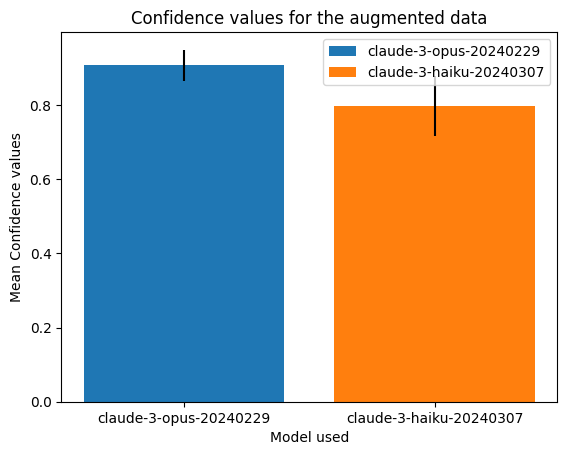

In [136]:
# loop thorugh results get the mean of the confidence values, group by model_used and print the results
from collections import defaultdict
results_grouped = defaultdict(list)
for key, value in results.items():
    results_grouped[value["model_used"]].append(value["confidence"])

for model, conf_values in results_grouped.items():
    conf_values = np.array(conf_values).flatten()
    print(f"confidence for model {model} -> {np.mean(conf_values)} ")

# plot the results for each group of models
# barplot with Xaxis the model used and Y the mean of the confidence values with error bars
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for model, conf_values in results_grouped.items():
    conf_values = np.array(conf_values).flatten()
    ax.bar(model, np.mean(conf_values), yerr=np.std(conf_values), label=model)

# title
plt.title('Confidence values for the augmented data')
# x-axis label
plt.xlabel('Model used')
# y-axis label
plt.ylabel('Mean Confidence values')
plt.legend()
plt.show()




